# Brain tumor examples

We use the open-sourced dataset __Bra__in **T**umor __S__egmentation dataset ([BraTS](https://www.med.upenn.edu/sbia/brats2018.html)) as a nice example of using deep learning for medical imaging tasks.  We can obtain BraTS directly from the [UPenn website](https://www.med.upenn.edu/sbia/brats2018.html) or via [Medical Decathlon](http://medicaldecathlon.com) which packages it along with 9 other datasets.

## Load one of the BraTS images

Fortunately, all medical imaging uses a common format called [DICOM](https://www.dicomstandard.org/) which is standardized across medical scanners (CT, MR, U/S, X-ray, PET)-- no matter which vendor is used. This makes medical imaging work easier because we have a standard way of working with the data. There are very nice open-sourced programs which allow us to easily work with DICOM files and convert them to NumPy array ([SimpleITK](http://www.simpleitk.org/), [pyDICOM](https://pydicom.github.io/))

BraTS uses the Nifti format to store MR images. Nifti, a variant of DICOM, is often used in MR images of the brain.  We use the [nibabel](https://nipy.org/nibabel/) library to load Nifti images. 

The 4 channels of the [MRI](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging) are the same image using different MRI filters:
* Fluid Attenuated Inversion Recovery (FLAIR) 
* T1
* T1-gadolinium
* T2

The most common MRI sequences are T1-weighted and T2-weighted scans. These have different contrast and brightness in different structures of the brain. In general, T1- and T2-weighted images differ in the brightness of the cerebral spinal fluid ([CSF](https://en.wikipedia.org/wiki/Cerebrospinal_fluid)). CSF is dark on T1-weighted imaging and bright on T2-weighted images. 

![https://casemed.case.edu/clerkships/neurology/Web%20Neurorad/MRI%20Basics.htm](t1t2flairbrain.jpg)
From:  https://casemed.case.edu/clerkships/neurology/Web%20Neurorad/MRI%20Basics.htm

Gadolinium (Gd) is a metal that can be injected into the blood stream to serve as a contrast agent in T1 scans. It's very helpful for highlighting blood vessels and areas where the blood-brain barrier has broken down (e.g. bleeding, inflammation, tumors).  

A third commonly used sequence is the Fluid Attenuated Inversion Recovery (FLAIR). This sequence is very sensitive to pathology because it essentially supresses the bright T2 signal from the CSF to allow abnormalities to better stand out in the image. For example, FLAIR allows tumors to remain bright but normal CSF fluid is attenuated and made dark. 

For more information, see:
https://casemed.case.edu/clerkships/neurology/Web%20Neurorad/MRI%20Basics.htm



In [2]:
!pip install nibabel

  Using cached nibabel-3.2.1-py3-none-any.whl (3.3 MB)


In [3]:
#!pip install nibabel
import nibabel as nib

import numpy as np

In [4]:
import matplotlib.pyplot as plt  # Help us plot nice images
%matplotlib inline

In [ ]:
filename = "BRATS_472.nii.gz"  # Filename to load
img = np.rot90(nib.load("imagesTr/{}".format(filename)).dataobj)  # Using nibabel to load the MRI image as NumPy array
msk = np.rot90(nib.load("labelTr/{}".format(filename)).dataobj)   # Using nibabel to load the tumor label as NumPy array

In [4]:
print("Each slice is 240x240 pixels. There are 155 slices in a 3D volume.")
print("The image resolution varies but is on the order of a 1 mm x 1 mm x 1.5 mm voxel.")
print("Image shape \t= {}".format(img.shape))
print("The 4 channels are FLAIR, T1, T1-gadolinium, and T2")
print("Mask shape \t= {}".format(msk.shape))

Each slice is 240x240 pixels. There are 155 slices in a 3D volume.
The image resolution varies but is on the order of a 1 mm x 1 mm x 1.5 mm voxel.
Image shape 	= (240, 240, 155, 4)
The 4 channels are FLAIR, T1, T1-gadolinium, and T2
Mask shape 	= (240, 240, 155)


The output labels were manually annotated by expert radiologists. The numbers represent: 
* 0: 'background' = normal brain
* 1: 'edema' = swelling
* 2: 'non-enhancing tumor' = part of the tumor that isn't enhanced by contrast
* 3: 'enhancing tumour' = part of the tumor that is enhanced by gadolinium contrast 

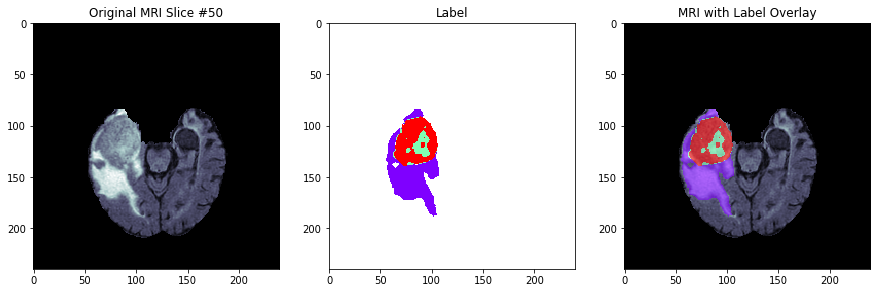

In [5]:
def plot_slice(slice_num):
    """
    Let's plot one slice with the labels.
    """
    # Set a mask where the background is located.
    background_masked = np.ma.masked_where(msk[:, :, slice_num] == 0, msk[:, :, slice_num])

    plt.figure(figsize=(15,15))  # Set the figure size

    plt.subplot(1,3,1)
    plt.imshow(np.array(img[:,:,slice_num,0]), cmap="bone");
    plt.title("Original MRI Slice #{}".format(slice_num));

    plt.subplot(1,3,2)
    plt.imshow(background_masked, cmap="rainbow");
    plt.title("Label");

    plt.subplot(1,3,3)
    plt.imshow(np.array(img[:,:,slice_num,0]), cmap="bone");
    plt.imshow(background_masked, alpha=0.6, cmap="rainbow");

    plt.title("MRI with Label Overlay");
    
    
plot_slice(50);  # Not all slices have tumors

In [6]:
#!conda install -y ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets

widgets.interact(plot_slice, slice_num=widgets.IntSlider(min=0,max=155,step=1,value=60));

interactive(children=(IntSlider(value=60, description='slice_num', max=155), Output()), _dom_classes=('widget-…

# Let's create a tumor classifier with TF Keras

Most of the slices in the MRI do not contain the tumor.  Let's just build a simple binary CNN classifier using TF Keras to determine if the slice has a tumor (class 1) or does not have a tumor (class 0).  

In [7]:
labels = np.zeros((msk.shape[2]))
for idx in range(msk.shape[2]):
    if (np.sum(np.sum(np.sum(msk[:,:,idx]))) > 0):
        labels[idx] = 1.0  # Tumor is present in the slice
        
print("There are {:.0f} of {} slices with a tumor in the slice ({:.2f}%).".format(np.sum(labels), msk.shape[2], 100.0* np.sum(labels)/msk.shape[2]))

There are 72 of 155 slices with a tumor in the slice (46.45%).


## Convolutional Neural Network (CNN) Binary Classifier

Let's use the TensorFlow Keras functional API to define a simple convolutional neural network.

The network will take the entire 240x240 image (with 4 MRI channels).  It will only work on the 155 slices from one patient file (so very toy test).

In [8]:
import tensorflow as tf
from tensorflow import keras as K

print("Is TensorFlow enabled with Intel optimizations? {}".format(tf.pywrap_tensorflow.IsMklEnabled()))

inputs_to_model = K.layers.Input((img.shape[0], img.shape[1], img.shape[3]), name="MRImage")   # We are passing the 240x240 image slice with 4 channels

layer1 = K.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="ed")(inputs_to_model)

layer2 = K.layers.Conv2D(filters=16, kernel_size=(5,5), padding="same", activation="relu", name="asti")(layer1)


pool2 = K.layers.MaxPooling2D(pool_size=(2,2), name="tony")(layer2)

layer3 = K.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name="garima")(pool2)

layer4 = K.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", name="thanos")(layer3)

flat1 = K.layers.Flatten()(layer4)

dense1 = K.layers.Dense(units=64, activation="relu", name="kara")(flat1)

dense2 = K.layers.Dense(units=16, activation="relu", name="ryan")(dense1)

# Output layer has 1 neuron (the predicted y value) and sigmoid activation (so it goes from 0 to 1)
prediction = K.layers.Dense(units=1, activation="sigmoid", name="tumorPresent")(dense2)


Is TensorFlow enabled with Intel optimizations? True


In [9]:
model = K.models.Model(inputs=[inputs_to_model], outputs=[prediction], name="MySuperCNNModel")

model.summary()  # Ask Keras to print the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MRImage (InputLayer)         (None, 240, 240, 4)       0         
_________________________________________________________________
ed (Conv2D)                  (None, 240, 240, 32)      1184      
_________________________________________________________________
asti (Conv2D)                (None, 240, 240, 16)      12816     
_________________________________________________________________
tony (MaxPooling2D)          (None, 120, 120, 16)      0         
_________________________________________________________________
garima (Conv2D)              (None, 120, 120, 64)      9280      
_________________________________________________________________
thanos (Conv2D)              (None, 120, 120, 32)      18464     
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
__________

You can use programs like [Netron](https://lutzroeder.github.io/netron/) to view the saved model. 

![CNN model](cnn_model.png)

## CNN math

Let's figure out how many trainable parameters are in each layer.

I've added a custom name to the layers.  The convolutional layers have 3x3 filters/kernels except for *prashant* which has a 5x5 convolutional kernel/filter.

The number of parameters is calculated by:

$ ( \text{kernel height} \times \text{kernel width} \times \text {# input channels} + 1 ) \times \text {number of filters} $

So for convolutional layer *tony* the number of trainable parameters for the layer is:

$ ( 3 \times 3 \times 4 + 1) \times 32 = 1,184$

### Keras maps itself to TensorFlow commands

For convolutional layer *prashant* the number of trainable parameters for the layer is:

$ (5 \times 5 \times 32 + 1) \times 16 = 12,816 $

The actual TensorFlow code generated by the Keras API would look something like this:

```python 
layer2 = K.layers.Conv2D(filters=16, kernel_size=(5,5), padding="same", activation="relu", name="prashant")(layer1)
```

becomes ...

```python 
def weight_variable(shape, name):
    """weight_variable generates a weight variable of a given shape."""
    weight_var = tf.get_variable(name, shape)
    return weight_var


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


# Convolutional layer2 -- maps 32 feature maps to 16.
with tf.name_scope("prashant"):
    
    # Keras knows the "32" because that was the size passed in by the input to the layer
    W_conv2 = weight_variable([5, 5, 32, 16], "W_conv2")    # The convolutional weight matrix
    b_conv2 = bias_variable([16])     # Adding the bias term
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)  # ReLU applied to convolution

```

### The remaining layers are what we have seen before.

The Flatten layer just takes the tensor and turns it into one long vector (nothing to train). It's just a simple reshape or unravel. So an \[H, W, C\] matrix becomes a \[1, H\*W\*C\] vector.

As explained in the first lesson, the Dense layers are just:

$(\text{number of input units + 1)} \times \text{number of output units}$

For the Dense layer labeled *abhishek*, it has an input of 460,800 and an output of 64 units. So the number of trainable parameters is:

$(460,800 + 1 \text{ for the bias unit}) \times 64 = 29,491,264 \text{ trainable parameters} $


## What is convolution doing?

Before 2012 researchers used [handmade convolutional filters](https://en.wikipedia.org/wiki/Kernel_(image_processing)) to generate algorithms for computer vision.  [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) showed that a neural network could "learn" good convolutional filters without any pre-training. It just needed to be fed a dataset of labeled images and a loss function to know how good the model was performing. AlexNet performed significantly better on the [ImageNet](http://www.image-net.org/) contest than any computer vision algorithm before it.

These convolutional filters are looking for edges, textures, and other basic components within an image.  It's an approach that says effectively: "A house is made up of a roof, walls, doors, and windows. A roof is made up of a triangle. Windows are made of panes which are made of rectangles. Etc. Etc." Typically, pooling layers are used (e.g. MaxPooling) to consider features at different spatial resolutions within the image (fine-grained to coarse).

There's an amazing online example of convolutional filters [here](http://setosa.io/ev/image-kernels/).

![what is convolution](what_is_convolution.png)

In [10]:
opt = K.optimizers.Adam(lr=1e-5)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

## Other optimizers

We chose the [Adam](https://keras.io/optimizers/) optimizer for this CNN (a common choice) which adds a momentum calculation to stochastic gradient descent (SGD).  There are many other optimizers for SGD. 

Now we just call `model.fit`.  Note that we need to re-order the `img` tensor so that it is (batch, height, width, channels) because that is what our model was told to expect.

In [11]:
# Here's what we need to get a TensorBoard log
tb_callback = K.callbacks.TensorBoard(log_dir='./tensorboard_logs')

# Now just call model.fit to train the model
history = model.fit(np.transpose(img, [2, 0, 1, 3]), labels, epochs=10, batch_size=64, verbose=1, validation_split=0.15, callbacks=[tb_callback])

Train on 131 samples, validate on 24 samples
Epoch 1/10
131/131 [==============================] - 3s 25ms/step - loss: 7.0376 - acc: 0.4351 - val_loss: 1.0405 - val_acc: 0.8750
Epoch 2/10
131/131 [==============================] - 2s 18ms/step - loss: 3.0147 - acc: 0.7481 - val_loss: 0.5152 - val_acc: 1.0000
Epoch 3/10
131/131 [==============================] - 2s 16ms/step - loss: 1.3836 - acc: 0.8473 - val_loss: 0.5097 - val_acc: 1.0000
Epoch 4/10
131/131 [==============================] - 2s 15ms/step - loss: 0.4051 - acc: 0.8931 - val_loss: 0.5085 - val_acc: 1.0000
Epoch 5/10
131/131 [==============================] - 2s 15ms/step - loss: 0.0605 - acc: 0.9771 - val_loss: 0.5092 - val_acc: 1.0000
Epoch 6/10
131/131 [==============================] - 2s 17ms/step - loss: 0.0762 - acc: 0.9847 - val_loss: 0.5091 - val_acc: 1.0000
Epoch 7/10
131/131 [==============================] - 2s 17ms/step - loss: 0.3298 - acc: 0.9695 - val_loss: 0.5084 - val_acc: 1.0000
Epoch 8/10
131/131 [====

## Training history

The history contains the information about the training curves. You can store it or make a plot of the curve as below.

Nevertheless, the [TensorBoard](https://keras.io/callbacks/#tensorboard) callback is the optimal way to view training curves. Try out TensorBoard if you plan to do serious deep learning models.

`tb_callback = K.callbacks.TensorBoard(log_dir='./tensorboard_logs', histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)`

To use TensorBoard run `tensorboard --logdir=./tensorboard_logs` from your conda environment (point it to whatever directory you saved the logs to. It will start a webservice that you can view in a [browser](http://localhost:6006).


In [12]:
print("The history contains data points for all of the metrics and losses: {}".format(print(history.history.keys())))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
The history contains data points for all of the metrics and losses: None


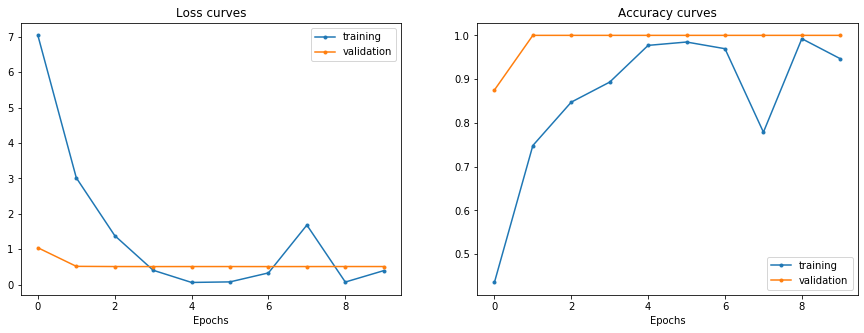

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], marker=".")
plt.plot(history.history["val_loss"], marker=".")
plt.xlabel("Epochs")
plt.legend(["training", "validation"])
plt.title("Loss curves");

plt.subplot(1,2,2)
plt.plot(history.history["acc"], marker=".")
plt.plot(history.history["val_acc"], marker=".")
plt.xlabel("Epochs")
plt.legend(["training", "validation"])
plt.title("Accuracy curves");

## Let's see how well the model does and generate some predictions

Obviously this is a toy example.

In [14]:
model_prediction = model.predict(np.transpose(img, [2, 0, 1, 3]), batch_size=1, verbose=1)

155/155 [==============================] - 1s 8ms/step


In [15]:
incorrect_predictions = np.where(np.round(np.squeeze(model_prediction)) != labels)[0]
correct_predictions = np.where(np.round(np.squeeze(model_prediction)) == labels)[0]
print("Out of {} slices, the trained model got these {} wrong: {}".format(img.shape[2], len(incorrect_predictions), incorrect_predictions))

Out of 155 slices, the trained model got these 5 wrong: [ 28 101 102 103 104]


Model prediction = 1.00, Ground truth = 1.0


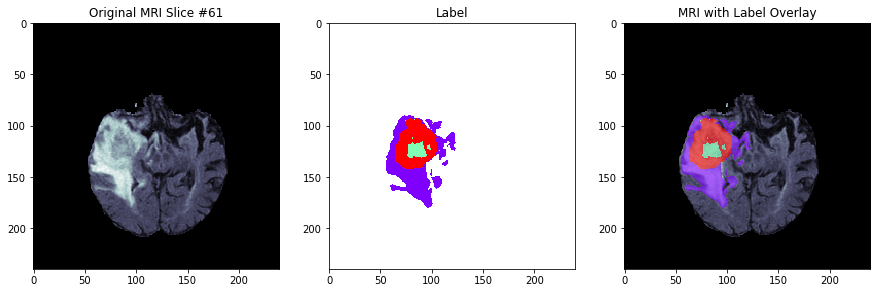

In [21]:
idx = np.random.choice(len(correct_predictions))
print("Model prediction = {:.2f}, Ground truth = {}".format(model_prediction[correct_predictions[idx]][0], labels[correct_predictions[idx]]))
plot_slice(correct_predictions[idx])

Model prediction = 0.98, Ground truth = 0.0


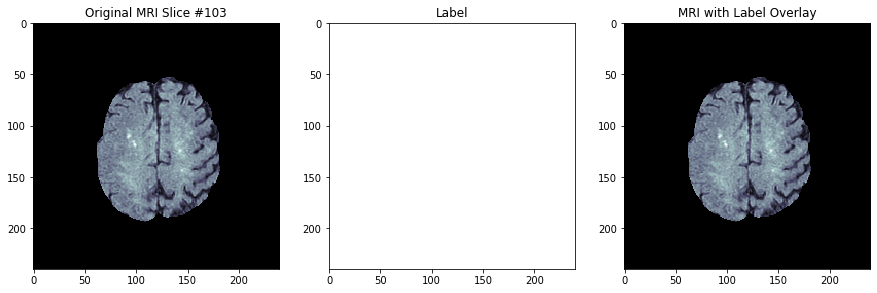

In [17]:
idx = np.random.choice(len(incorrect_predictions))
print("Model prediction = {:.2f}, Ground truth = {}".format(model_prediction[incorrect_predictions[idx]][0], labels[incorrect_predictions[idx]]))
plot_slice(incorrect_predictions[idx])

Model prediction = 0.000, Ground truth = 0.0


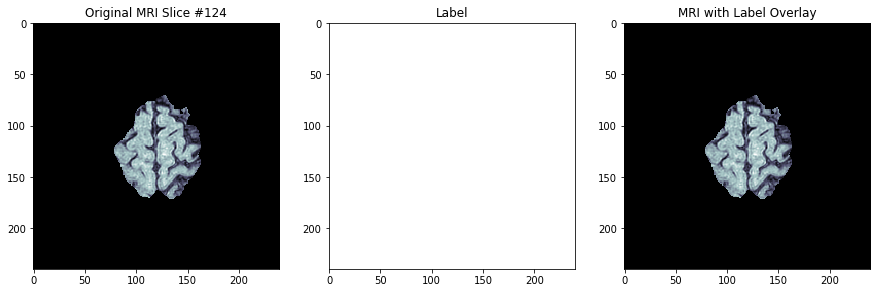

In [18]:
idx = np.random.choice(correct_predictions[np.where(labels[correct_predictions] == 0.0)[0]])
print("Model prediction = {:.3f}, Ground truth = {}".format(model_prediction[correct_predictions[idx]][0], labels[correct_predictions[idx]]))
plot_slice(correct_predictions[idx])

Model prediction = 1.000, Ground truth = 1.0


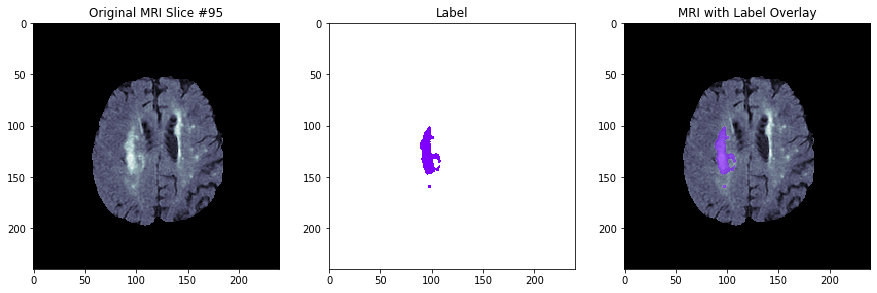

In [19]:
idx = np.random.choice(correct_predictions[np.where(labels[correct_predictions] == 1.0)[0]])
print("Model prediction = {:.3f}, Ground truth = {}".format(model_prediction[correct_predictions[idx]][0], labels[correct_predictions[idx]]))
plot_slice(correct_predictions[idx])

## Don't forget to save the trained model for use later

In [20]:
model.save("my_awesome_cnn_brats_model")